# DSLabs functions

In [24]:
%run "scripts/dslabs_functions.py"


# Data functions

In [1]:
%run "scripts/data_functions.py"

import pandas as pd
import numpy as np



data_functions loaded


# Load

In [2]:


file_tag = "Google Merch Store 2024-2025"


# smoothed time series with split. uncomment to use
# train=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_train.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)
# test=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_test.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)




# unsmoothed time series with split to test the model. uncomment to use
test_split_threshold = 0.7
data_no_smoothing=pd.read_csv('data/df_merch_0_2024_agg_time_diff_input.csv', decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)     
train, test = series_train_test_split(data_no_smoothing, trn_pct=test_split_threshold)



target='Sessions'

# Prepare the training and testing data from dataframes with features and target
trnX = train.drop(columns=[target])
trnY = train[target]
tstX = test.drop(columns=[target])
tstY = test[target]


from numpy import arange

# Ensure no data leakage
assert not set(train.index).intersection(set(test.index)), "Data leakage detected: Train and test sets overlap."


# # Prepare the training and testing data using the time index as the feature
# trnX = arange(len(train)).reshape(-1, 1)
# trnY = train[target].to_numpy()
# tstX = arange(len(train), len(train+test)).reshape(-1, 1)
# tstY = test[target].to_numpy()



train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 298 entries, 2024-01-05 to 2024-10-28
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Sessions                         298 non-null    float64
 1   Seven-day active users           298 non-null    float64
 2   28-day active users              298 non-null    float64
 3   Events per session               298 non-null    float64
 4   Add to baskets                   298 non-null    float64
 5   Checkouts                        298 non-null    float64
 6   E-commerce purchases             298 non-null    float64
 7   Average purchase revenue         298 non-null    float64
 8   Purchase revenue                 298 non-null    float64
 9   Average session duration         298 non-null    float64
 10  ARPU                             298 non-null    float64
 11  ARPPU                            298 non-null    float64
 12  Vie

## Simple Average

## Simple Average evaluate

In [3]:
from sklearn.base import RegressorMixin


class SimpleAvgRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.mean: float = 0.0
        return

    def fit(self, X: Series):
        self.mean = X.mean()
        return

    def predict(self, X: Series) -> Series:
        prd: list = len(X) * [self.mean]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

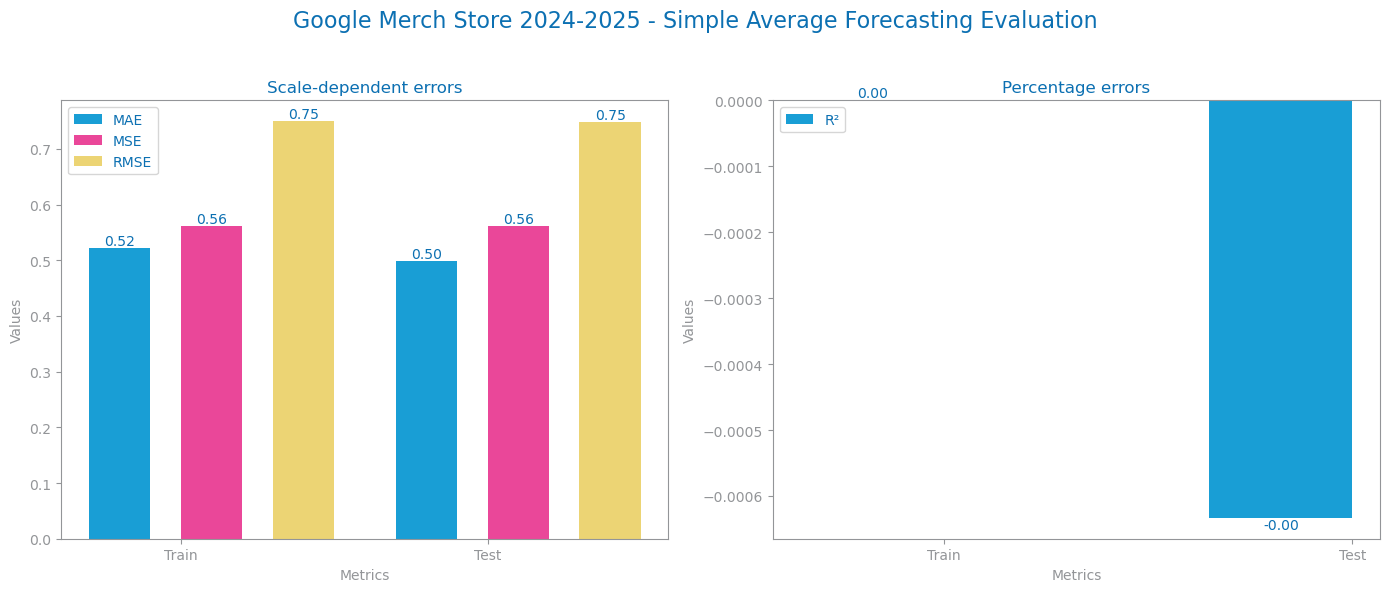

<Figure size 640x480 with 0 Axes>

In [4]:

import pandas as pd

# Fit the Model
model = SimpleAvgRegressor()
model.fit(pd.Series(trnY))

# Predict the training and testing data
prd_trn = pd.Series(model.predict(pd.Series(train[target])), index=train.index)
prd_tst = pd.Series(model.predict(pd.Series(test[target])), index=test.index)

# Plot the forecasting evaluation
plot_single_model_evaluation(train[target], test[target], prd_trn, prd_tst, title=f"{file_tag} - Simple Average Forecasting Evaluation")
savefig(f"images/{file_tag}_simple_average_evaluation.png")

## Simple Average Forecasting

<Axes: xlabel='Date', ylabel='Sessions'>

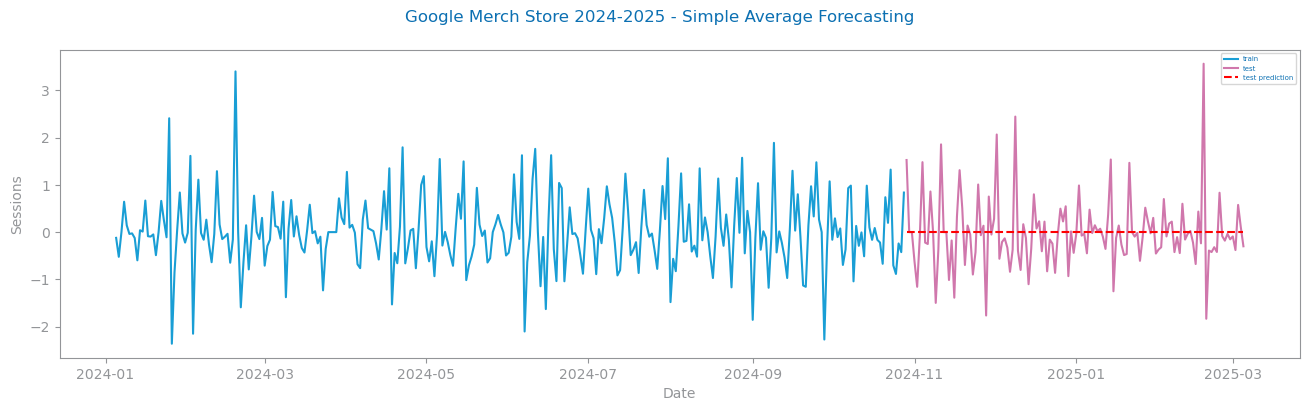

In [5]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Simple Average Forecasting",
    xlabel='Date',
    ylabel=target,
)

# Persistence Model

## Persistence One Step Ahead Definition

In [6]:
from pandas import Series
from sklearn.base import RegressorMixin


class PersistenceOptimistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last: float = 0.0
        return

    def fit(self, X: Series):
        self.last = X.iloc[-1]
        # print(self.last)
        return

    def predict(self, X: Series):
        prd: list = X.shift().values.ravel()
        prd[0] = self.last
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series
    
    
class PersistenceOneStepAhead(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.y = None

    def fit(self, y: Series):
        self.y = y

    def predict(self, y):
        if isinstance(y, Series):
            prd = self.y.shift(1)
            prd.iloc[0] = self.y.iloc[0]  # Set the first value to the first value of the original series
        else:
            prd = np.roll(self.y, 1)
            prd[0] = self.y[0]
        return prd

### Persistence One Step Ahead Eval

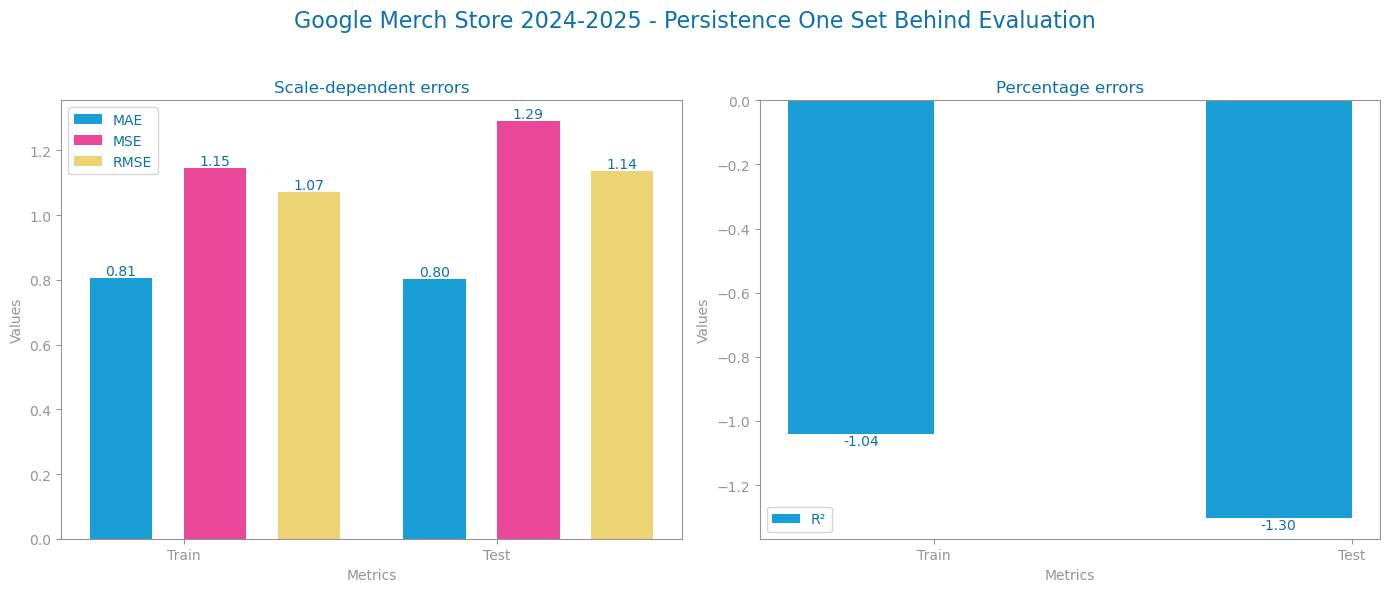

<Figure size 640x480 with 0 Axes>

In [7]:

# Fit the Model
model = PersistenceOptimistRegressor()
# model = PersistenceOneStepAhead()


# Fit the model with the cleaned training data
model.fit(trnY)

# Predict the training and testing data using the cleaned data
prd_trn_step = Series(model.predict(trnY), index=trnY.index)
prd_tst_step = Series(model.predict(tstY), index=tstY.index)



# Plot the forecasting evaluation
plot_single_model_evaluation(trnY, tstY, prd_trn_step, prd_tst_step, title=f"{file_tag} - Persistence One Set Behind Evaluation")
savefig(f"images/{file_tag}_persistence_one_step_ahead_evaluation.png")

### Persistence One Step Ahead Plot

<Axes: xlabel='Date', ylabel='Sessions'>

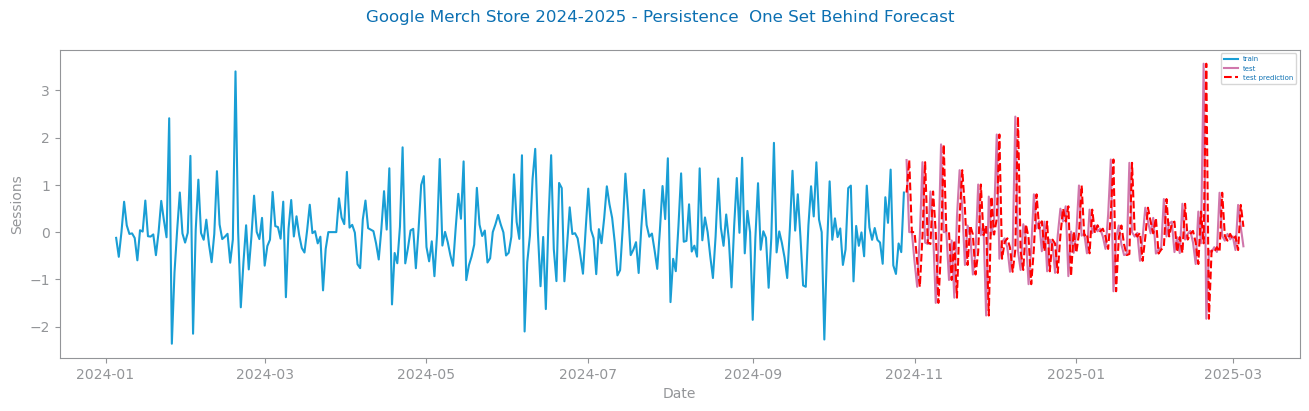

In [8]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst_step,
    title=f"{file_tag} - Persistence  One Set Behind Forecast",
    xlabel='Date',
    ylabel=target,
)

## Persistence Long Term Definition

In [9]:
class PersistenceRealistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last = 0
        self.estimations = [0]
        self.obs_len = 0

    def fit(self, X: Series):
        for i in range(1, len(X)):
            self.estimations.append(X.iloc[i - 1])
        self.obs_len = len(self.estimations)
        self.last = X.iloc[len(X) - 1]
        prd_series: Series = Series(self.estimations)
        prd_series.index = X.index
        return prd_series

    def predict(self, X: Series):
        prd: list = len(X) * [self.last]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series
    
    
class PersistenceLongTerm:
    def fit(self, y):
        self.last_value = y.iloc[-1]

    def predict(self, y):
        return np.repeat(self.last_value, len(y))

### Persistance Long Term Eval

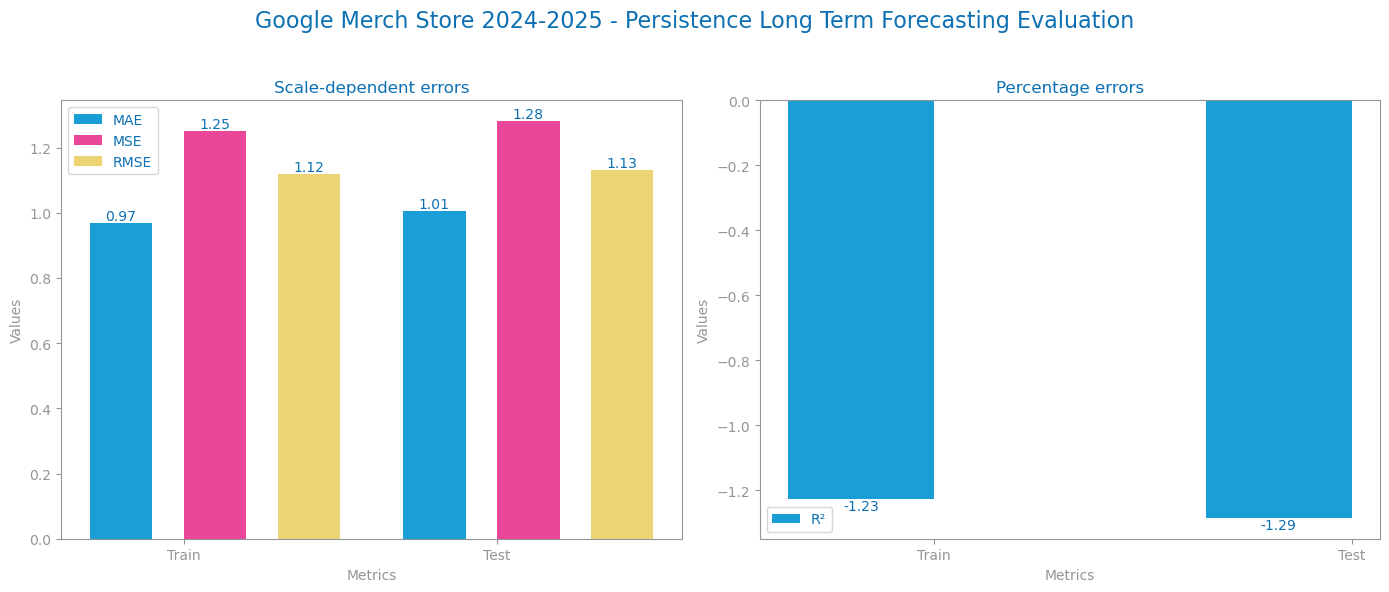

<Figure size 640x480 with 0 Axes>

In [10]:

# Fit the Model
# model = PersistenceRealistRegressor()
model = PersistenceLongTerm()
model.fit(trnY)

# Predict the training and testing data
prd_trn_long = Series(model.predict(trnY), index=train.index)
prd_tst_long = Series(model.predict(tstY), index=test.index)

# Plot the forecasting evaluation
plot_single_model_evaluation(train[target], test[target], prd_trn_long, prd_tst_long, title=f"{file_tag} - Persistence Long Term Forecasting Evaluation")
savefig(f"images/{file_tag}_persitence_realist_evaluation.png")

### Presistence Long Term Forecasting

<Axes: xlabel='Date', ylabel='Sessions'>

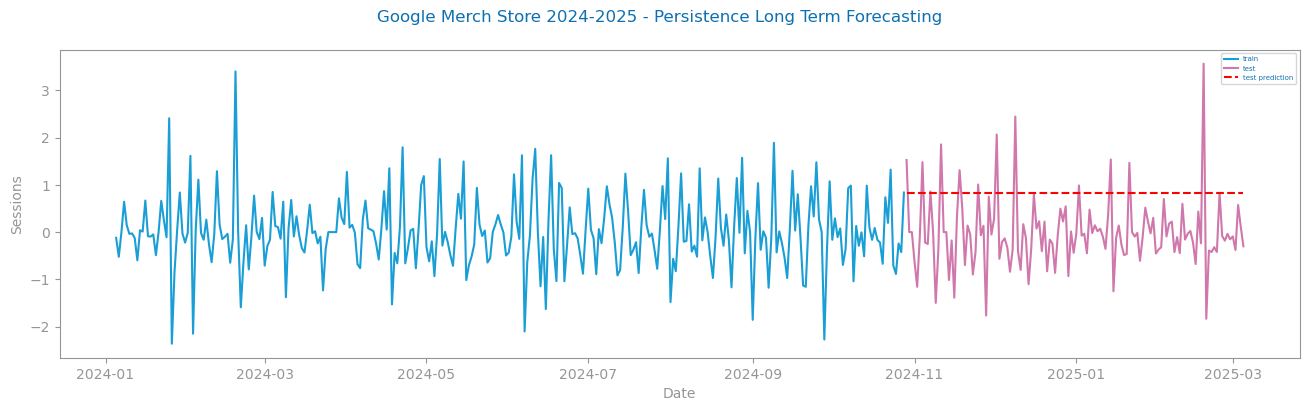

In [11]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst_long,
    title=f"{file_tag} - Persistence Long Term Forecasting",
    xlabel='Date',
    ylabel=target,
)

## Persistence Model Comparison

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10  # Small constant to avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Calculate performance metrics for each model
persistence_metrics = {
    "Model": ["Persistence One Set Behind", f"Persistence Long Term"],
    "MAE": [
        mean_absolute_error(test[target], prd_tst_step),
        mean_absolute_error(test[target], prd_tst_long),
    ],
    "MSE": [
        mean_squared_error(test[target], prd_tst_step),
        mean_squared_error(test[target], prd_tst_long),
    ],
    "RMSE": [
        mean_squared_error(test[target], prd_tst_step, squared=False),
        mean_squared_error(test[target], prd_tst_long, squared=False),
        
    ],
    "R²": [
        r2_score(test[target], prd_tst_step),
        r2_score(test[target], prd_tst_long),
    ],
    "MAPE": [
        mean_absolute_percentage_error(test[target], prd_tst_step),
        mean_absolute_percentage_error(test[target], prd_tst_long),
    ]
}

# Create a DataFrame to display the metrics
persistence_performance_df = pd.DataFrame(persistence_metrics)
print(persistence_performance_df)

                        Model       MAE       MSE      RMSE        R²  \
0  Persistence One Set Behind  0.802421  1.290424  1.135968 -1.302396   
1       Persistence Long Term  1.005838  1.280761  1.131707 -1.285155   

           MAPE  
0  4.457370e+10  
1  3.921047e+10  


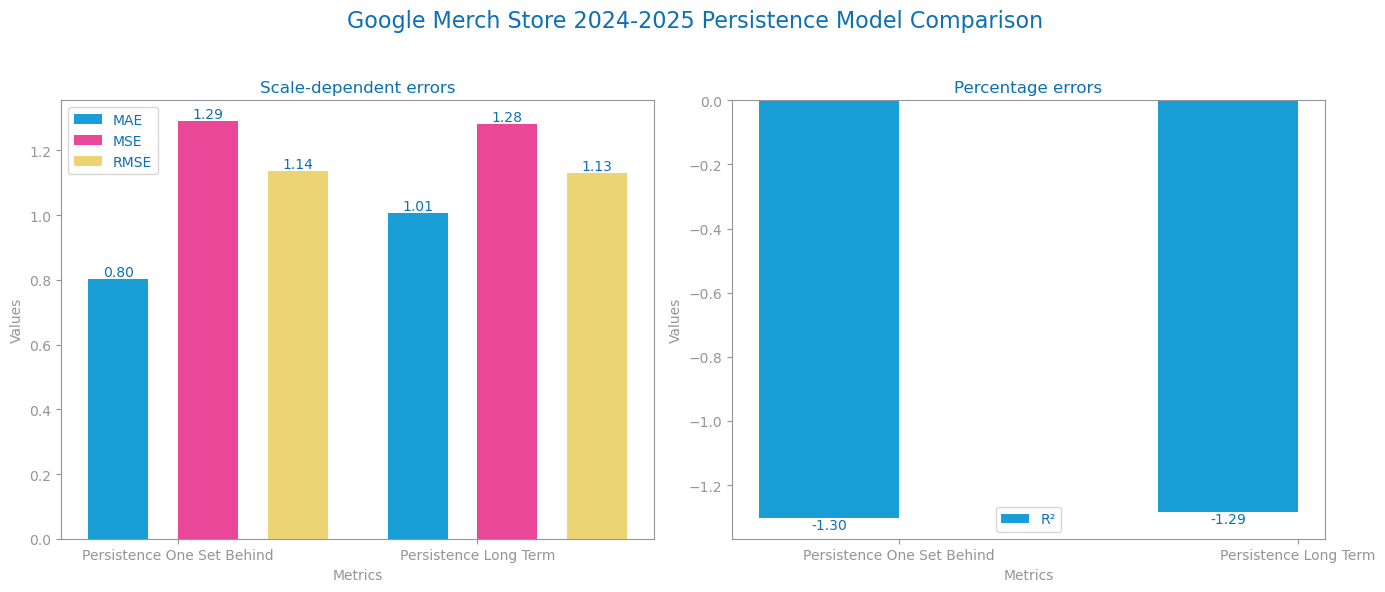

In [13]:
plot_performance_metrics(persistence_metrics, title=f"{file_tag} Persistence Model Comparison")

# Exponential Smoothing

### Exponential Smoothing Study

In [14]:
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


def exponential_smoothing_study(train: Series, test: Series, measure: str = "R2"):
    alpha_values = [i / 20 for i in range(1, 20)]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Exponential Smoothing", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for alpha in alpha_values:
        tool = SimpleExpSmoothing(train)
        model = tool.fit(smoothing_level=alpha, optimized=False)
        prd_tst = model.forecast(steps=len(test))

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (alpha,)
            best_model = model
        yvalues.append(eval)

    print(f"Exponential Smoothing best with alpha={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        alpha_values,
        yvalues,
        title=f"{file_tag} | Exponential Smoothing Study | {measure}",
        xlabel="alpha",
        ylabel=measure,
        percentage=flag,
    )

    return best_model, best_params

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

Exponential Smoothing best with alpha=0 -> R2=-0.00043192702469663224


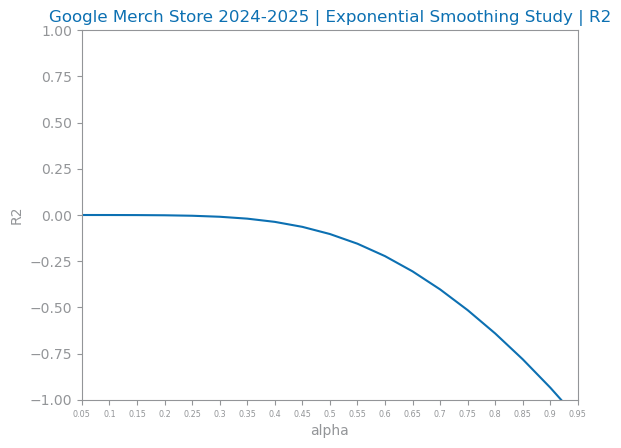

In [15]:
from matplotlib.pyplot import savefig

measure: str = "R2"


best_model, best_params = exponential_smoothing_study(trnY, tstY, measure=measure)
savefig(f"images/{file_tag}_exponential_smoothing_{measure}_study.png")

### Exponential Study Evaluate

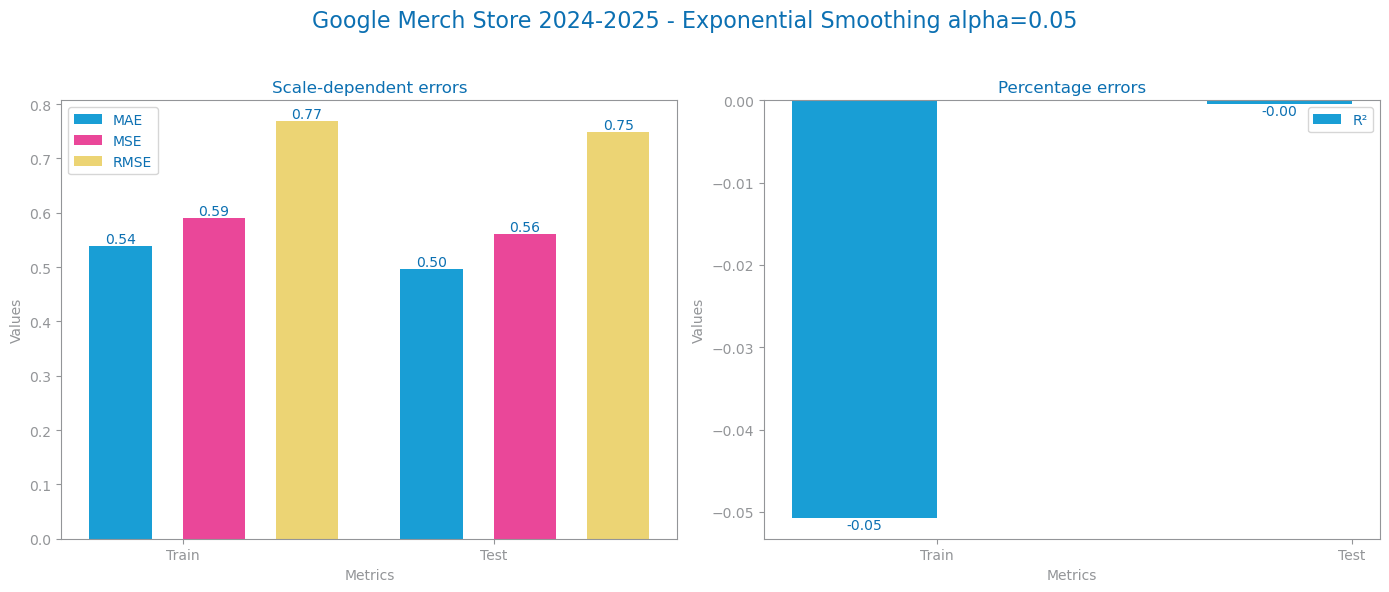

<Figure size 640x480 with 0 Axes>

In [16]:
params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(trnY) - 1)
prd_tst = best_model.forecast(steps=len(tstY))

plot_single_model_evaluation(trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Exponential Smoothing alpha={params[0]}")
savefig(f"images/{file_tag}_exponential_smoothing_{measure}_eval.png")

### Exponential Smoothing Forecast Plot

<Axes: xlabel='Date', ylabel='Sessions'>

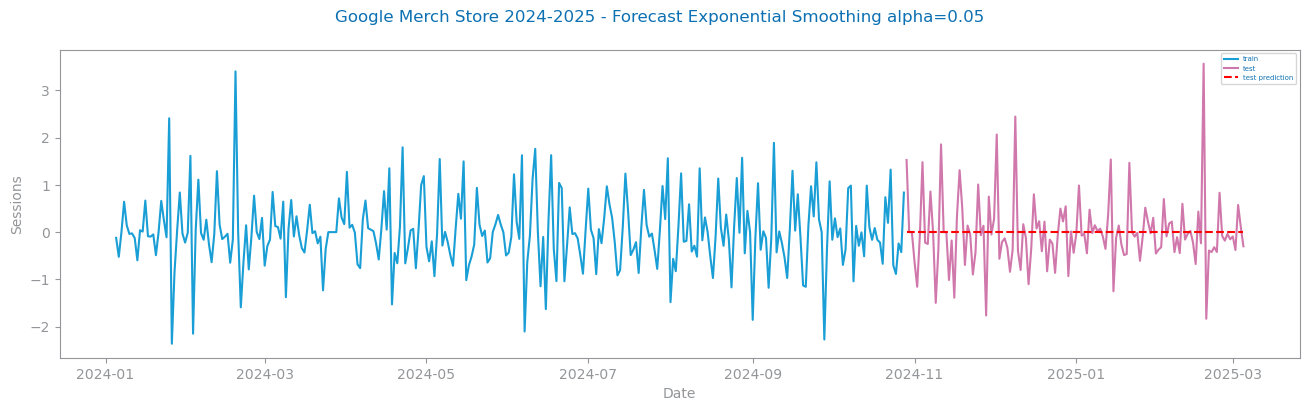

In [17]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Forecast Exponential Smoothing alpha={params[0]}",
    xlabel='Date',
    ylabel=target,
)

# Rolling Mean

In [18]:
from numpy import mean
from sklearn.base import RegressorMixin



class RollingMeanRegressor(RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win
        self.memory: list = []

    def fit(self, X: Series):
        self.memory = X.iloc[-self.win_size :]
        # print(self.memory)
        return

    def predict(self, X: Series):
        estimations = self.memory.tolist()
        for i in range(len(X)):
            new_value = mean(estimations[len(estimations) - self.win_size - i :])
            estimations.append(new_value)
        prd_series: Series = Series(estimations[self.win_size :])
        prd_series.index = X.index
        return prd_series

### Rolling Mean Study

NOT WORKING

Rolling Mean best with win=14 -> R2=-3.617808340461437e-06


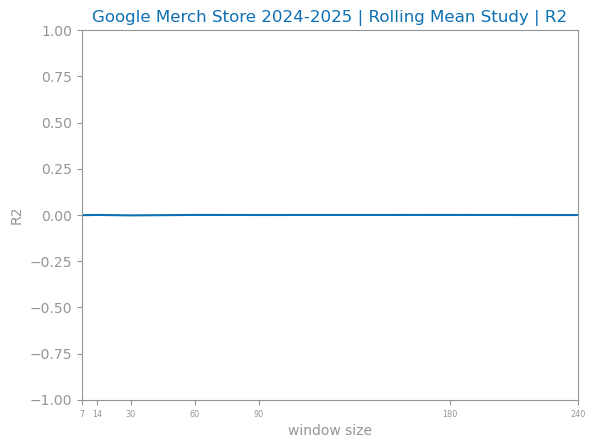

In [19]:
def rolling_mean_study(train: Series, test: Series, measure: str = "R2"):
    win_size = (7, 14, 30, 60, 90, 180, 240)  # Updated window sizes for daily data
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Rolling Mean", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    train_series = pd.Series(train)
    test_series = pd.Series(test)
    for w in win_size:
        pred = RollingMeanRegressor(win=w)
        pred.fit(train_series)
        prd_tst = pred.predict(test_series)
        prd_tst = prd_tst[:len(test_series)]  # Ensure the predicted series has the same length as the test series

        eval: float = FORECAST_MEASURES[measure](test_series, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (w,)
            best_model = pred
        yvalues.append(eval)

    print(f"Rolling Mean best with win={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        win_size, yvalues, title=f"{file_tag} | Rolling Mean Study | {measure}", xlabel="window size", ylabel=measure, percentage=flag
    )

    return best_model, best_params

best_model, best_params = rolling_mean_study(trnY, tstY)
savefig(f"images/{file_tag}_rollingmean_{measure}_study.png")

### Rolling Mean Evaluation

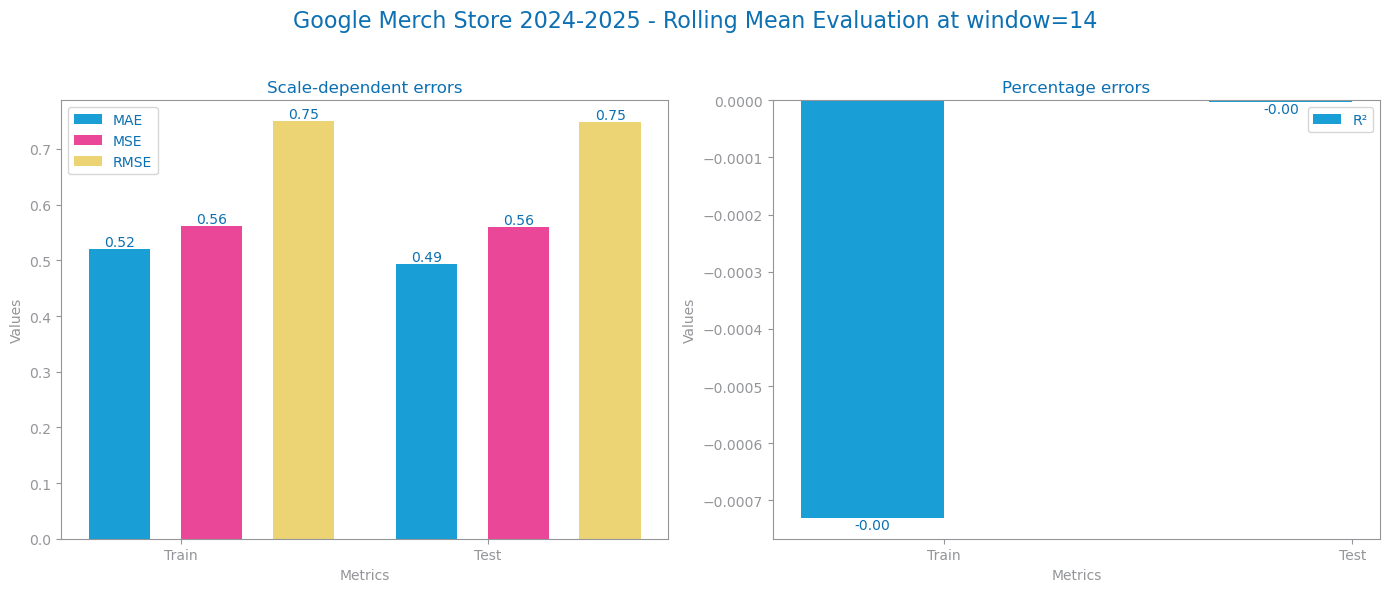

<Figure size 640x480 with 0 Axes>

In [20]:
params = best_params["params"]
prd_trn = best_model.predict(trnY)
prd_tst = best_model.predict(tstY)

plot_single_model_evaluation(trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Rolling Mean Evaluation at window={params[0]}")
savefig(f"images/{file_tag}_rolling_mean_{measure}_eval.png")

### Rolling Mean Plot Forecast

<Axes: xlabel='Date', ylabel='Sessions'>

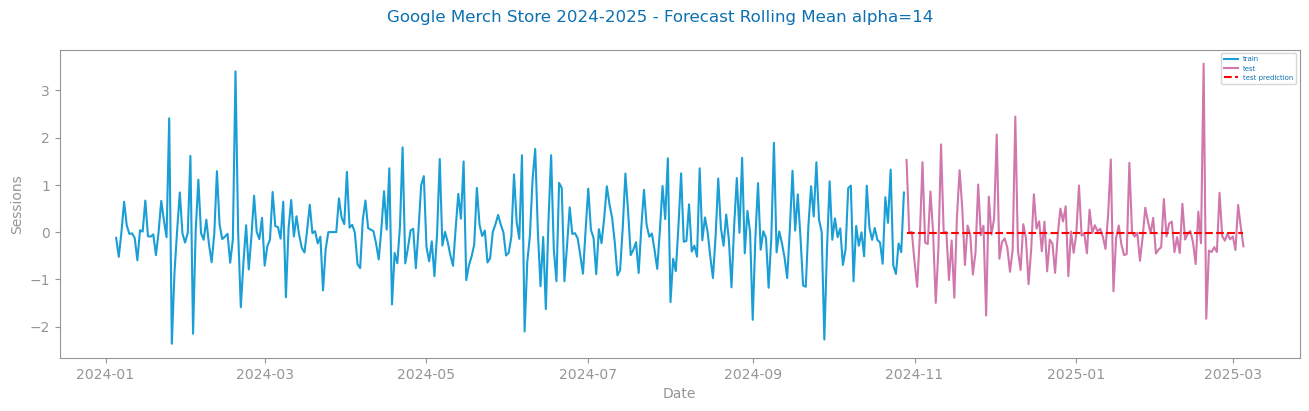

In [21]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Forecast Rolling Mean alpha={params[0]}",
    xlabel='Date',
    ylabel=target,
)

# Linear Regression

## Linear Regression Evaluate

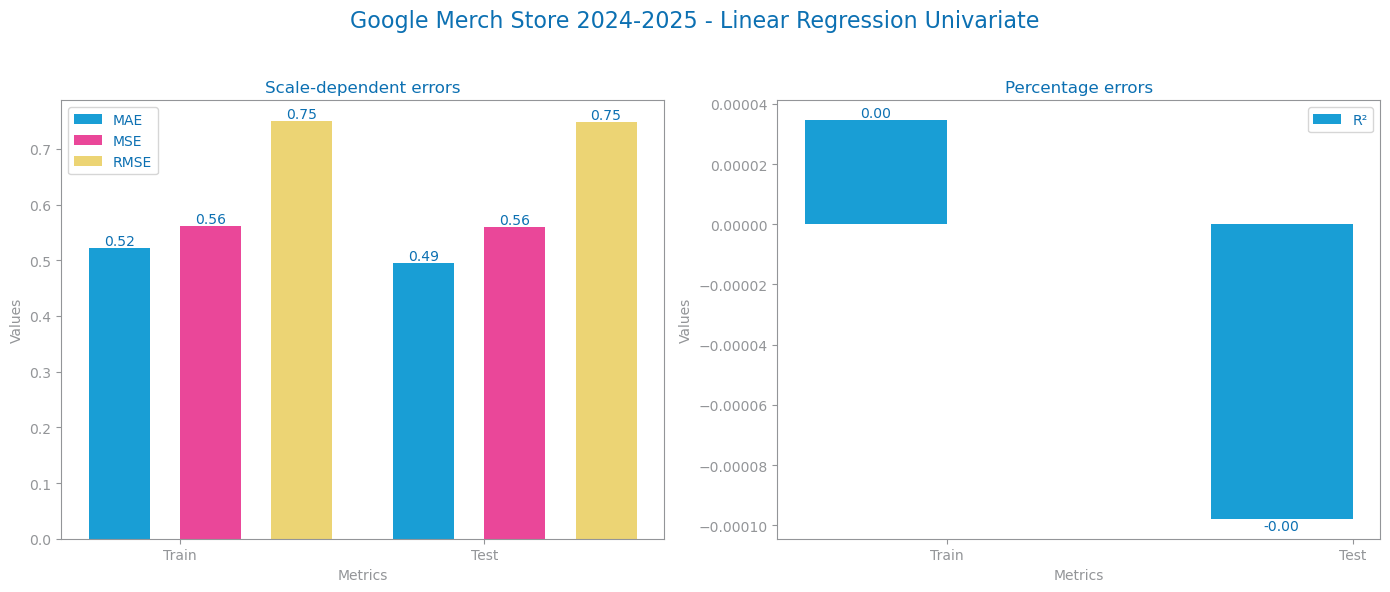

<Figure size 640x480 with 0 Axes>

In [22]:
from pandas import Series
from dslabs_functions import plot_forecasting_eval
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare the training and testing data using the time index as the feature
trnX = arange(len(train)).reshape(-1, 1)
trnY = train[target].to_numpy()
tstX = arange(len(train), len(train+test)).reshape(-1, 1)
tstY = test[target].to_numpy()


# Fit the linear regression model
model_1 = LinearRegression()
model_1.fit(trnX, trnY)

# Predict the training and testing data
prd_trn = Series(model_1.predict(trnX), index=train.index)
prd_tst = Series(model_1.predict(tstX), index=test.index)



# Plot the forecasting evaluation
plot_single_model_evaluation(train[target], test[target], prd_trn, prd_tst, title=f"{file_tag} - Linear Regression Univariate")
savefig(f"images/{file_tag}_linear_regression_univariate.png")

## Linear Regression Plot

<Axes: xlabel='Date', ylabel='Sessions'>

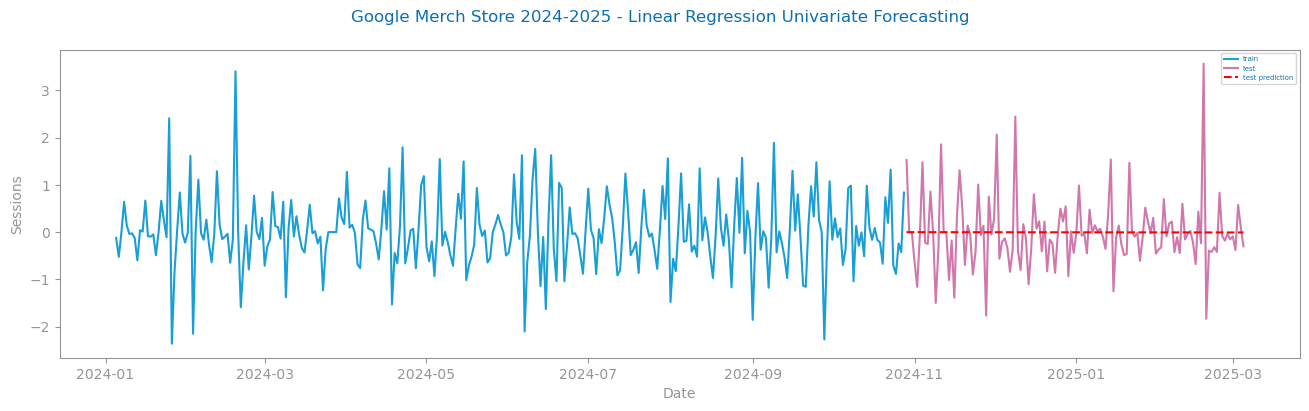

In [23]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - Linear Regression Univariate Forecasting",
    xlabel='Date',
    ylabel=target,
)